<h1 align="center">Deep learning a gyakorlatban Python és LUA alapon | VITMAV45</h1>
<h2 align="center">Nagy házi feladat</h2>

Team: Molehub

Team members:
* Küttel Dániel (QPPXW1) email:kutteljr@gmail.com
* Siket Máté (N1C4Z9) email:siket.mate@gmail.com


Topic: Mole detection with deep learning

<h2 align="center">I. milestone</h2>

### 1.1 Motivation
The current neural networks are developed for diagnose melanoma based on dermatoscopic images. On the other hand, during consultations we determined a different kind of approach. Our goal is to mark the moles on pictures which are taken from different distances at different angles, resolutions and lighting conditions. The "cutouts" could be later used for detailed investigation or mole appareance follow-up.

### 1.2 Main tasks during the semester
* Data acquistion & preprocess
* Train
* Data augmentation
* Hyperparameter tuning

Regarding the <i>I. milestone</i> our task is invloving data acquisiton, labeling, preprocessing standardization and in general to make an organized dataset which will be later applicable for training purposes.

### 1.3 Data acquistion & preprocess
In our case we could not find any perfect database that fits our problem, so we decided to collect photos from the internet and labeled them.

#### 1.3.1 Data acquistion and labeling
Some examples from our raw database:

Libraries for reading and plotting images:

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Following code reads two examples from our raw database.

For labeling purposes we used the labelImg software, which can be found https://github.com/tzutalin/labelImg here. The outputs are .xml files which contain the corresponding file name, resolution, path, bounding boxes of the selected image regions. Until the writing of this document we labeled more than 300 images, containing more than a 1000 moles.

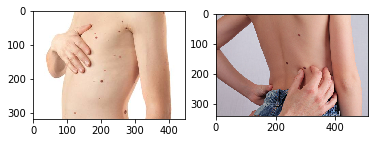

In [2]:
example_img1=plt.imread('DataBase1/14.jpg')
example_img2=plt.imread('DataBase1/176.jpg')
figure = plt.figure()
figure.add_subplot(1,2,1)
plt.imshow(example_img1)
figure.add_subplot(1,2,2)
plt.imshow(example_img2)
plt.show()

#### 1.3.2 Preprocessing

We imported the following libraries for preprocessing purposes:

In [3]:
from PIL import Image
import os
import xml.etree.ElementTree as ET

The following code iterates through our collected and labeled images. In the process we crop the moles and save them into separate files based on the previously generated .xml files. The cropped images also rescaled, thus the output images become 32x32 3-channel 8bit images in .bmp file format.

In [4]:
i_mole = 1
for i_database in range(1,3):#iterating through our databases
    for i_image in range(1,250):#iterating through the images
        if os.path.exists('DataBase%d/%d.xml' % (i_database, i_image)):#checking existance of file
            tree = ET.parse('DataBase%d/%d.xml' % (i_database, i_image))#reading the i-th .xml files
            root = tree.getroot()
            img = Image.open('DataBase%d/%d.jpg' % (i_database, i_image))#reading the i-th image
            for mole in root.findall('object'):#iterating through the labeled objects
                box = mole.find('bndbox')#acquiring the bounding box of the mole
                xmin = int(box.find('xmin').text)
                xmax = int(box.find('xmax').text)
                ymax = int(box.find('ymax').text)
                ymin = int(box.find('ymin').text)
                area = (xmin, ymin, xmax, ymax)
                cropped_img = img.crop(area)#cropping the image
                cropped_img = cropped_img.resize((32,32))#resizing the image
                cropped_img.save('Cropped/%d.bmp' % (i_mole))#saving the image
                i_mole += 1

We present two examples of the cropped moles:

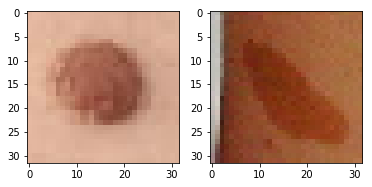

In [5]:
example_mole1=plt.imread('Cropped/8.bmp')
example_mole2=plt.imread('Cropped/810.bmp')
figure = plt.figure()
figure.add_subplot(1,2,1)
plt.imshow(example_mole1)
figure.add_subplot(1,2,2)
plt.imshow(example_mole2)
plt.show()

The following code iterates through the selected images, which will provide samples for non-mole elements. Notation for the background elements is (<i>bckg</i>). We distribute 56 points in one image evenly where we sample 32x32 regions. The cropped images checked afterwards for eliminate the unlikely events when the samples contain moles.

In [6]:
i_bckg = 1
for i_img in range(1,250):
    if os.path.exists('DataBaseBCKG/%d.jpg' % (i_img)):#checking existance of file
        img = Image.open('DataBaseBCKG/%d.jpg' % (i_img))#reading the i-th image
        width, height = img.size
        x_scale = int(width/8-1)#distance between samples in x direction
        y_scale = int(height/8-1)#distance between samples in y direction
        for x_point in range(1,8):
            for y_point in range(1,8):
                area = (x_point*x_scale-16, y_point*y_scale-16, x_point*x_scale+16, y_point*y_scale+16)#sampled area
                cropped_img = img.crop(area)#cropping the image
                cropped_img.save('CroppedBCKG/%d.bmp' % (i_bckg))#saving the image
                i_bckg += 1

We present two examples of the non-mole cropped images:

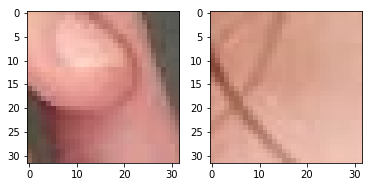

In [7]:
example_bckg1=plt.imread('CroppedBCKG/4.bmp')
example_bckg2=plt.imread('CroppedBCKG/117.bmp')
figure = plt.figure()
figure.add_subplot(1,2,1)
plt.imshow(example_bckg1)
figure.add_subplot(1,2,2)
plt.imshow(example_bckg2)
plt.show()

#### 1.3.3 Data organization and standardization

Libraries for creating the dataset:

In [8]:
import numpy as np
from random import shuffle
import glob

The following code reads the cropped images and organizes into a random sequenced tuple structure based on the label.

It is not a mole.


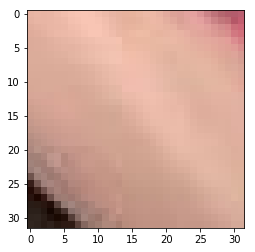

In [59]:
imgs = []
labels = []
i_file = 1
for file_path in glob.glob('Cropped/*.bmp'):  #grabbing path of the cropped images
    bckg_path = ('CroppedBCKG/%d.bmp' % i_file) #grabbing path of the background images
    if file_path and bckg_path:
        imgs.append(np.asarray(Image.open(file_path)))  #reading mole images and labels
        labels.append(1) #reading background images and labels
        imgs.append(np.asarray(Image.open(bckg_path)))  #reading mole images and labels
        labels.append(0) #reading background images and labels
    i_file += 1   

imgs = np.asarray(imgs)
labels = np.asarray(labels)
    
s = np.arange(len(imgs))
np.random.shuffle(s)
imgs = imgs[s]
labels = labels[s]

dataset = [imgs, labels]

#Example:
#Second dim: i-th image
#First dim: 0 - image data; 1 - label data
plt.imshow(dataset[0][0])
if dataset[1][0]==1:
    print('It is a mole.')
else:
    print('It is not a mole.')
    
# organize the dataset into a tuple
dataset = (dataset[0], dataset[1])

<h2 align="center">II. milestone</h2>

### 2.1 Train

Import packages for training.

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
from keras import backend as K
from keras import regularizers
from keras.utils import np_utils

#### 2.1.1 preprocess
The following code separates the dataset into validation, test and train subsets. Based on the training set standardization executed on the three sets.

In [62]:
# mole or not mole
nb_classes = 2

# separating inputs and outputs
X, Y = dataset

# ratio of validation samples
test_split = 0.1
valid_split = 0.1

#Indeces of the subsets
v_index = int(X.shape[0]*(1-valid_split-test_split))
t_index = int(X.shape[0]*(1-test_split))

#Splitting the dataset into test, validation and train subsets
X_train = X[:t_index].astype('float32')
Y_train = Y[:t_index]
X_valid = X[v_index:t_index].astype('float32')
Y_valid = Y[v_index:t_index]
X_test = X[t_index:].astype('float32')
Y_test = Y[t_index:]

# dimensions of our images.
img_width, img_height = X_train.shape[1], X_train.shape[2]

# standard
X_train = X_train / 255
X_valid = X_valid / 255
X_test = X_test / 255

print('X_train max: ',X_train.max())
print('X_train min: ',X_train.min())
print('X_valid max: ',X_valid.max())
print('X_valid min: ',X_valid.min())
print('X_test max: ',X_test.max())
print('X_test min: ',X_test.min())

print('X train shape: ', X_train.shape)
print('Y train shape: ', Y_train.shape)
print('X valid shape: ', X_valid.shape)
print('Y valid shape: ', Y_valid.shape)
print('X test shape: ', X_test.shape)
print('Y test shape: ', Y_test.shape)
print(X_train.shape[0], 'train samples')

X_train max:  1.0
X_train min:  0.0
X_valid max:  1.0
X_valid min:  0.0
X_test max:  1.0
X_test min:  0.0
X train shape:  (2514, 32, 32, 3)
Y train shape:  (2514,)
X valid shape:  (279, 32, 32, 3)
Y valid shape:  (279,)
X test shape:  (280, 32, 32, 3)
Y test shape:  (280,)
2514 train samples


one hot encoded & channel format

In [52]:
# convert class vectors to binary class matrices:
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_valid = np_utils.to_categorical(Y_valid, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_width, img_height)
    X_valid = X_valid.reshape(X_valid.shape[0], 3, img_width, img_height)
    X_test = X_test.reshape(X_test.shape[0], 3, img_width, img_height)
    input_shape = (3, img_width, img_height)
else:
    X_train = X_train.reshape(X_train.shape[0], img_width, img_height, 3)
    X_valid = X_valid.reshape(X_valid.shape[0], img_width, img_height, 3)
    X_test = X_test.reshape(X_test.shape[0], img_width, img_height, 3)
    input_shape = (img_width, img_height, 3)

#### 2.1.2 Define CNN

The convnet by https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

<i>"The code snippet below is our first model, a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers. This is very similar to the architectures that Yann LeCun advocated in the 1990s for image classification (with the exception of ReLU)."</i>

In [53]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(nb_classes, activation='sigmoid',
                kernel_regularizer=regularizers.l2(0.0001)
               ))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_4 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_5 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 64)          18496     
__________

#### 2.1.3 Train

In [54]:
batch_size = 16
epochs = 100

# Next, setting the early stopping
# and define checkpoint, so we can load the best state back
patience=40
early_stopping=EarlyStopping(patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='cnn_weights.hdf5', save_best_only=True, verbose=1)

network_history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_valid, Y_valid),
#           validation_split=0.2,
          callbacks=[checkpointer, early_stopping])

Train on 2514 samples, validate on 279 samples
Epoch 1/100
2514/2514 [==============================] - 1s 548us/step - loss: 0.4159 - acc: 0.7971 - val_loss: 0.2552 - val_acc: 0.9283

Epoch 00001: val_loss improved from inf to 0.25519, saving model to cnn_weights.hdf5
Epoch 2/100
2514/2514 [==============================] - 1s 286us/step - loss: 0.2228 - acc: 0.9200 - val_loss: 0.1975 - val_acc: 0.9319

Epoch 00002: val_loss improved from 0.25519 to 0.19747, saving model to cnn_weights.hdf5
Epoch 3/100
2514/2514 [==============================] - 1s 276us/step - loss: 0.1933 - acc: 0.9352 - val_loss: 0.1948 - val_acc: 0.9355

Epoch 00003: val_loss improved from 0.19747 to 0.19475, saving model to cnn_weights.hdf5
Epoch 4/100
2514/2514 [==============================] - 1s 284us/step - loss: 0.1734 - acc: 0.9403 - val_loss: 0.1501 - val_acc: 0.9498

Epoch 00004: val_loss improved from 0.19475 to 0.15010, saving model to cnn_weights.hdf5
Epoch 5/100
2514/2514 [==========================


Epoch 00040: val_loss did not improve from 0.00834
Epoch 41/100
2514/2514 [==============================] - 1s 288us/step - loss: 0.0393 - acc: 0.9873 - val_loss: 0.0238 - val_acc: 0.9928

Epoch 00041: val_loss did not improve from 0.00834
Epoch 42/100
2514/2514 [==============================] - 1s 291us/step - loss: 0.0164 - acc: 0.9944 - val_loss: 0.0091 - val_acc: 1.0000

Epoch 00042: val_loss did not improve from 0.00834
Epoch 43/100
2514/2514 [==============================] - 1s 281us/step - loss: 0.0117 - acc: 0.9968 - val_loss: 0.0313 - val_acc: 0.9928

Epoch 00043: val_loss did not improve from 0.00834
Epoch 44/100
2514/2514 [==============================] - 1s 281us/step - loss: 0.0289 - acc: 0.9916 - val_loss: 0.0085 - val_acc: 0.9964

Epoch 00044: val_loss did not improve from 0.00834
Epoch 45/100
2514/2514 [==============================] - 1s 278us/step - loss: 0.0241 - acc: 0.9920 - val_loss: 0.0119 - val_acc: 1.0000

Epoch 00045: val_loss did not improve from 0.0083

2514/2514 [==============================] - 1s 275us/step - loss: 0.0140 - acc: 0.9956 - val_loss: 0.0070 - val_acc: 0.9964

Epoch 00082: val_loss did not improve from 0.00119
Epoch 83/100
2514/2514 [==============================] - 1s 274us/step - loss: 0.0080 - acc: 0.9976 - val_loss: 0.0071 - val_acc: 1.0000

Epoch 00083: val_loss did not improve from 0.00119
Epoch 84/100
2514/2514 [==============================] - 1s 288us/step - loss: 0.0053 - acc: 0.9988 - val_loss: 0.0055 - val_acc: 1.0000

Epoch 00084: val_loss did not improve from 0.00119
Epoch 85/100
2514/2514 [==============================] - 1s 284us/step - loss: 0.0034 - acc: 0.9992 - val_loss: 0.0045 - val_acc: 1.0000

Epoch 00085: val_loss did not improve from 0.00119
Epoch 86/100
2514/2514 [==============================] - 1s 285us/step - loss: 0.0043 - acc: 0.9992 - val_loss: 0.0060 - val_acc: 1.0000

Epoch 00086: val_loss did not improve from 0.00119
Epoch 87/100
2514/2514 [==============================] - 1s 27

### 2.2 Results

In [55]:
def plot_history(network_history):
    figure = plt.figure(figsize=(20,20))
    figure.add_subplot(2,1,1)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'], fontsize=18)

    figure.add_subplot(2,1,2)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'])
    
    plt.show()

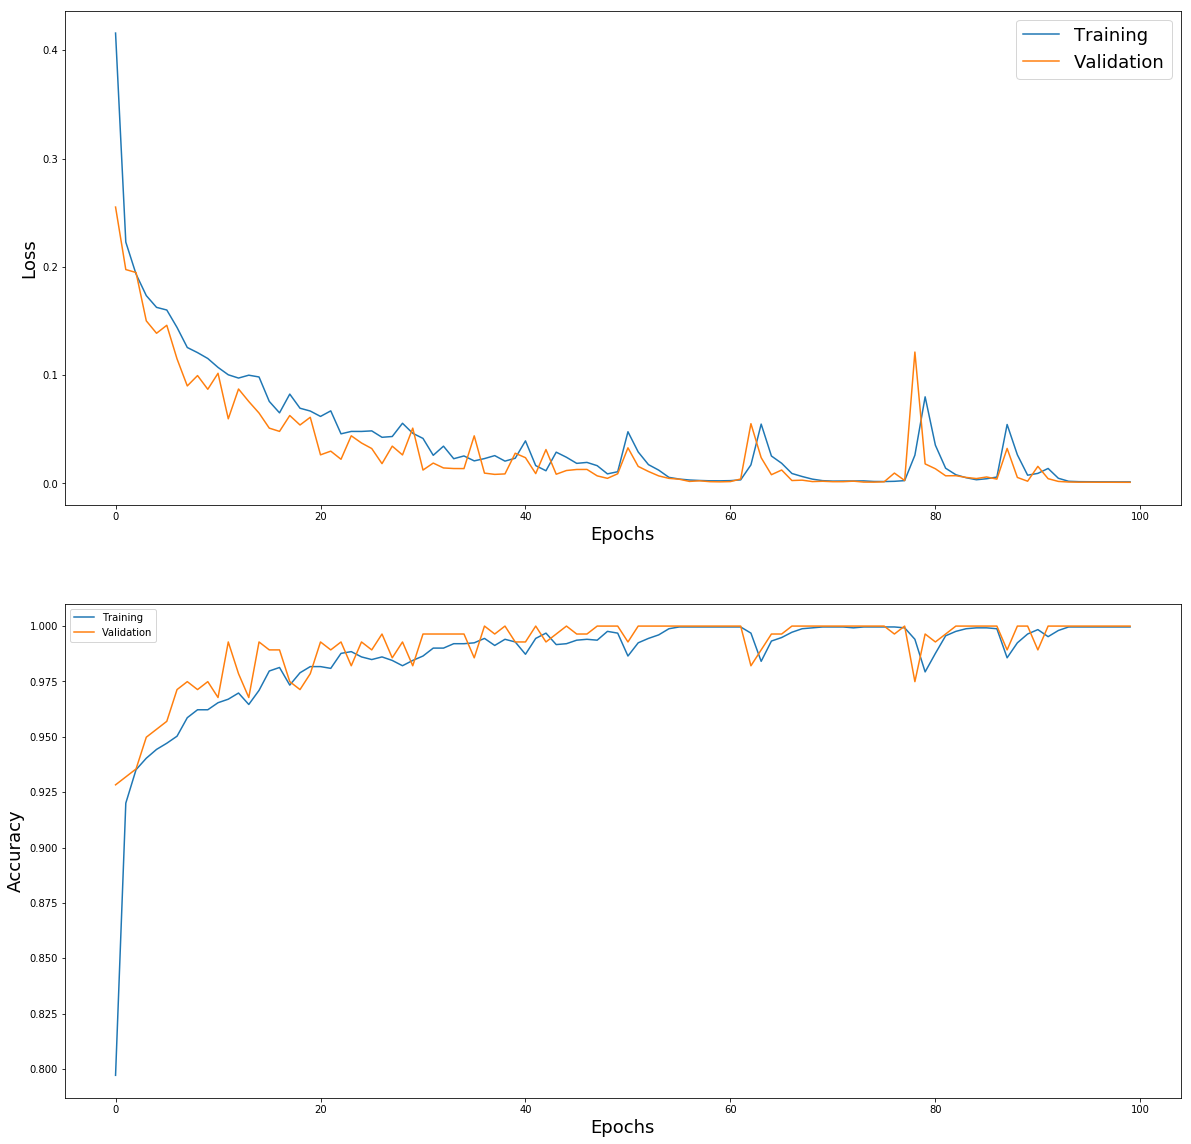

In [56]:
plot_history(network_history)

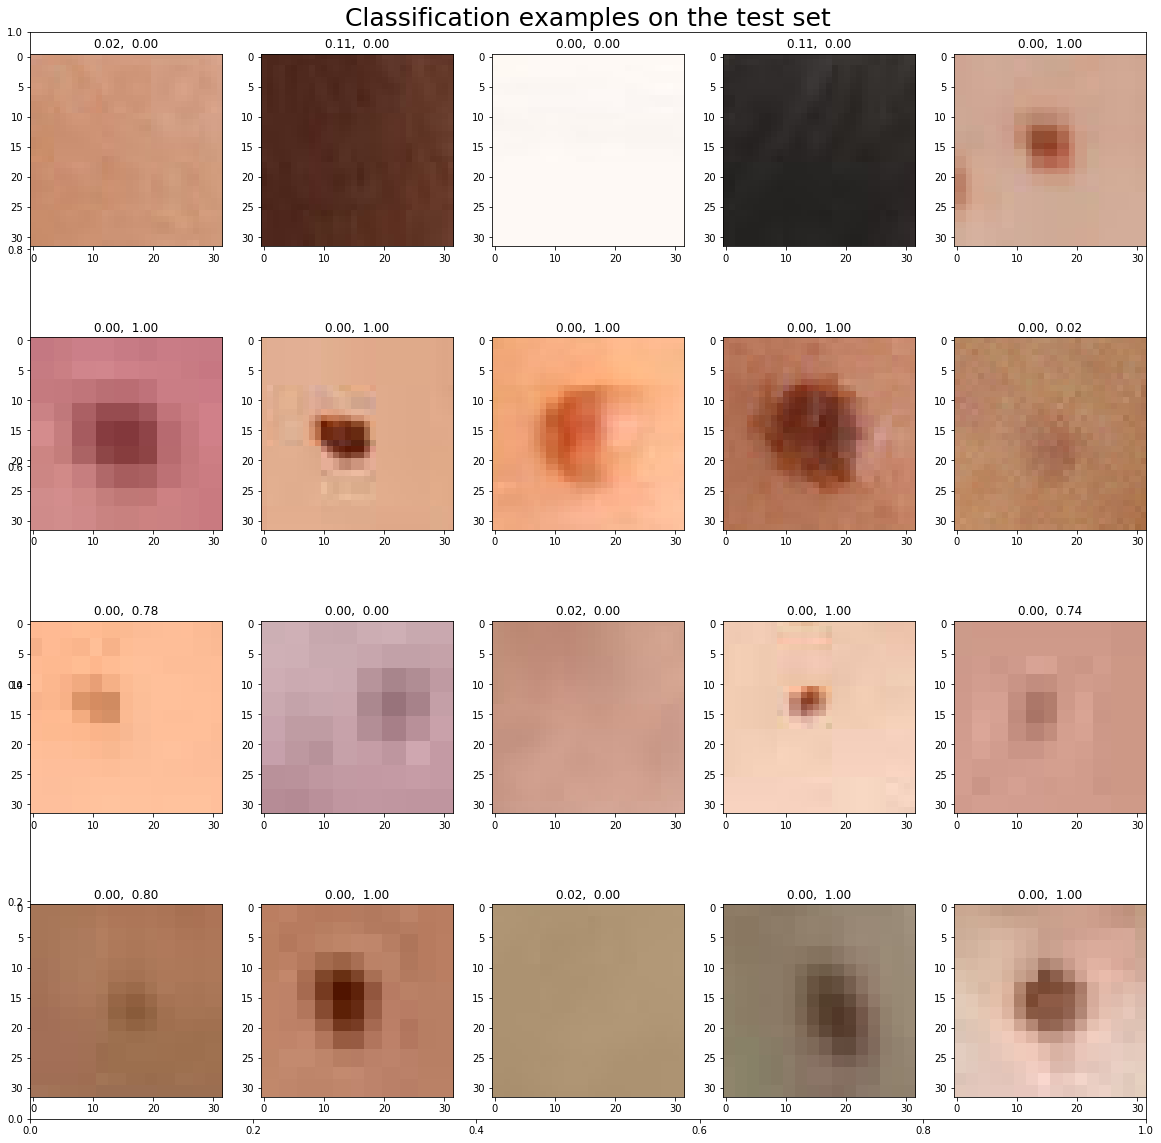

In [63]:
model = load_model('cnn_weights.hdf5')
pred = model.predict(X_test[:20])

i=0
figure = plt.figure(figsize=(20,20))
plt.title("Classification examples on the test set", fontsize=25)

for value in pred:
    title = str("%0.2f" % np.asscalar(value[0])) + ',  ' + str("%0.2f" % np.asscalar(value[1]))
    figure.add_subplot(4,5,i+1)
    plt.imshow(X_test[i])
    plt.title(title)
    i+=1

plt.show()

### 2.3 Object detector

In [39]:
from scipy import misc as msc
from sklearn.metrics import mean_squared_error

In [81]:
diagimg = np.asarray(Image.open('DataBase1/3.jpg'))
shift = np.array([10,20,40], dtype=np.uint8)
size = np.array([32,64,128], dtype=np.uint8)

i = 0

for i_shift, i_size in zip(shift, size):
    for step_y in range(0,3):
        for step_x in range(0,3):
                diagimg = diagimg[i_shift*step_y:,i_shift*step_x:]
#                 print(i_size)
                w1 = diagimg[0:(diagimg.shape[0]//i_size)*i_size,0:(diagimg.shape[1]//i_size)*i_size]
                w1c = np.split(w1, w1.shape[0]//i_size, axis = 0)
                w1c = np.asarray(w1c)
                w1c = np.split(w1c, w1c.shape[2]//i_size, axis = 2)
                w1c = np.asarray(w1c)
                w1c = np.reshape(w1c, (w1c.shape[0]*w1c.shape[1],i_size,i_size,3))
                if i_size > 32:
                    w1c = np.resize(w1c, (w1c.shape[0],32,32,3))
                #w1c = np.reshape(w1c, (w1c.shape[0],i_size,i_size))
                if i==0:
                    w1input = w1c
                    i += 1
                else:
                    w1input = np.append(w1input, w1c, axis = 0)
#                 print(w1input.shape)
                
w1Scaled = w1input/255
w1Scaled = np.reshape(w1Scaled, (w1Scaled.shape[0], w1Scaled.shape[1], w1Scaled.shape[2], 3))

[1.6082559e-09 9.9987411e-01]
Press Enter to continue...


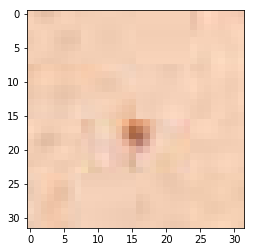

[6.501560e-33 9.606091e-01]
Press Enter to continue...


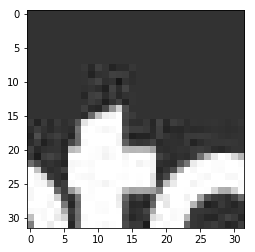

[1.3065204e-09 8.3884150e-01]
Press Enter to continue...


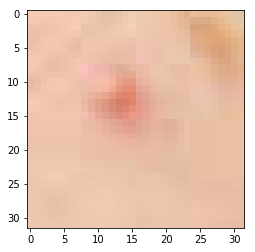

[8.500034e-11 9.999957e-01]
Press Enter to continue...


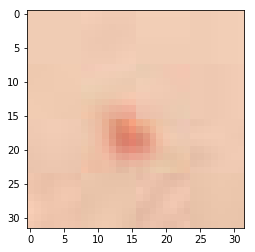

[2.7212852e-07 9.4517398e-01]
Press Enter to continue...


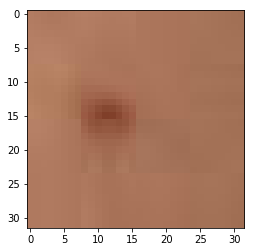

[2.9341156e-12 9.9956948e-01]
Press Enter to continue...


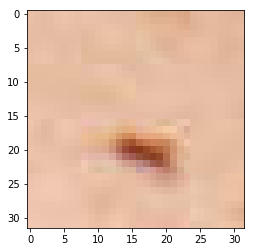

[3.4351606e-12 1.0000000e+00]
Press Enter to continue...


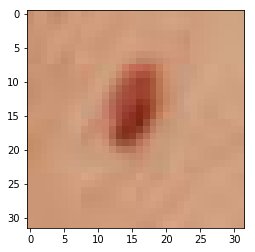

[3.0936104e-12 1.0000000e+00]
Press Enter to continue...


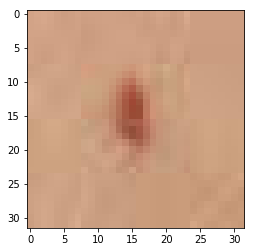

[1.8521305e-08 9.9938858e-01]
Press Enter to continue...


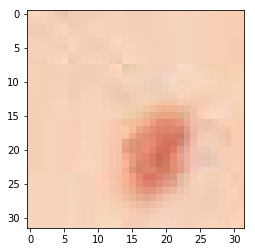

[8.1778745e-07 7.6444608e-01]
Press Enter to continue...


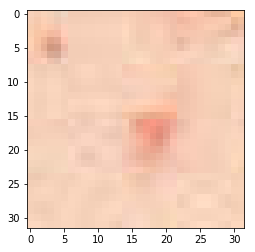

[1.7598680e-06 9.9998605e-01]
Press Enter to continue...


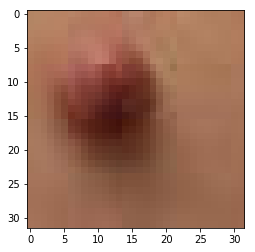

[1.2045769e-08 9.8442072e-01]
Press Enter to continue...


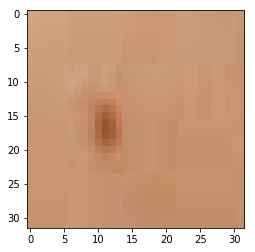

[6.484687e-12 9.997631e-01]
Press Enter to continue...


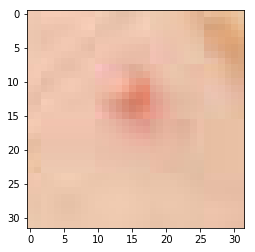

[2.0519122e-09 9.9999630e-01]
Press Enter to continue...


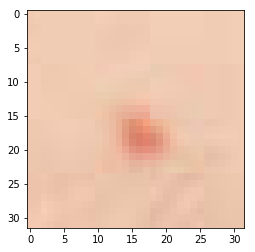

[2.0716977e-06 9.6775025e-01]
Press Enter to continue...


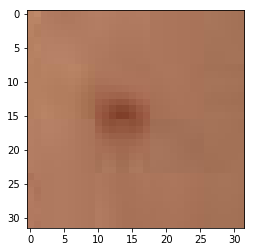

[2.269415e-09 9.514343e-01]
Press Enter to continue...


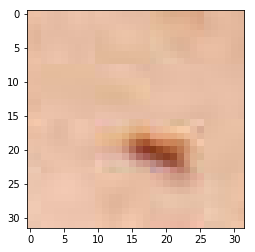

[5.4393027e-12 6.2706316e-01]
Press Enter to continue...


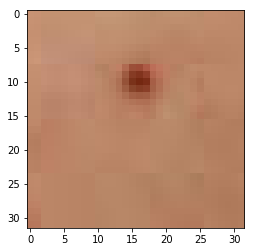

[9.7019934e-11 1.0000000e+00]
Press Enter to continue...


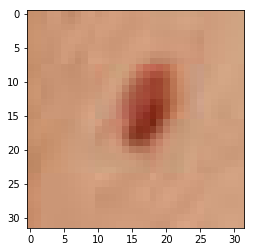

[1.2025853e-10 9.9999988e-01]
Press Enter to continue...


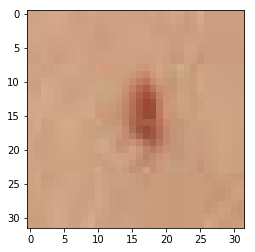

[9.1057905e-14 9.9838281e-01]
Press Enter to continue...


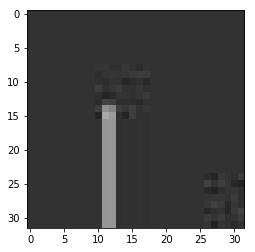

[6.4660522e-15 9.1831154e-01]
Press Enter to continue...


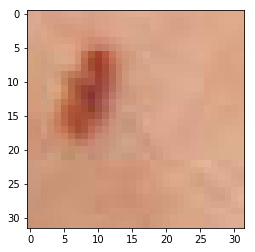

[5.9450395e-10 9.9004221e-01]
Press Enter to continue...


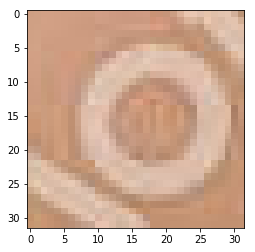

[2.128497e-09 9.994436e-01]
Press Enter to continue...


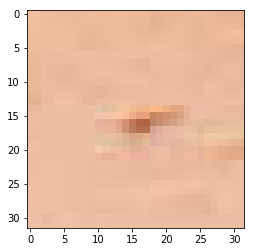

[6.4634847e-12 9.9273008e-01]
Press Enter to continue...


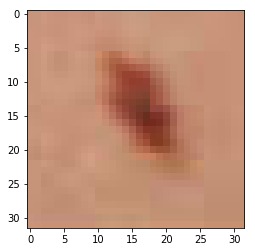

[3.5030906e-10 7.1202832e-01]
Press Enter to continue...


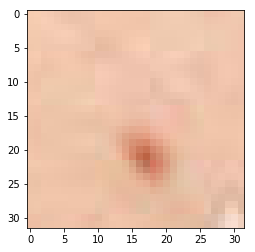

[0.         0.99994826]
Press Enter to continue...


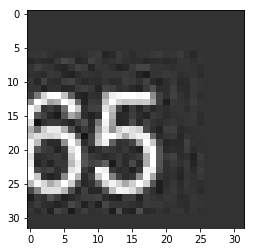

[4.9450864e-11 1.0000000e+00]
Press Enter to continue...


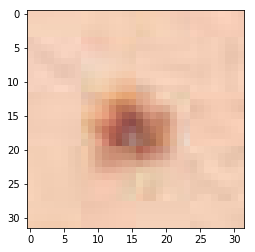

[2.2854463e-05 9.7908574e-01]
Press Enter to continue...


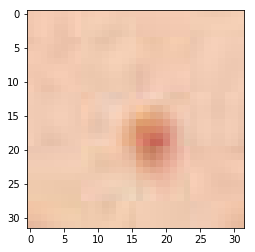

[1.1656634e-10 9.9999714e-01]
Press Enter to continue...


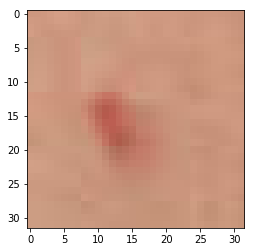

[1.31599055e-11 9.99999404e-01]
Press Enter to continue...


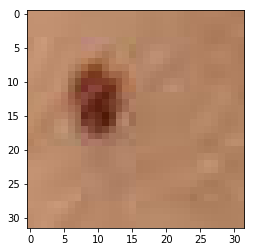

[1.4357747e-10 9.9875915e-01]
Press Enter to continue...


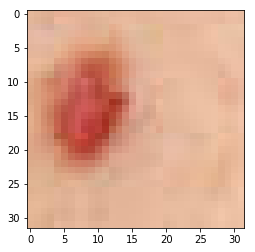

[7.6229134e-11 9.9997139e-01]
Press Enter to continue...


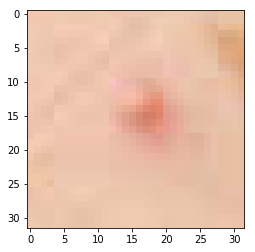

[5.189378e-08 8.914339e-01]
Press Enter to continue...


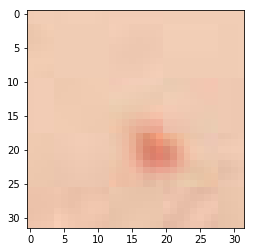

[2.2747633e-06 9.9882537e-01]
Press Enter to continue...


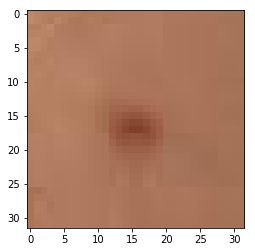

[2.4605154e-06 7.5370109e-01]
Press Enter to continue...


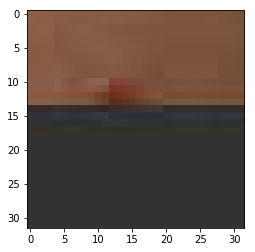

[4.7985588e-11 9.9999988e-01]
Press Enter to continue...


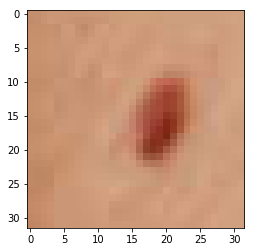

[1.8324869e-09 9.9978024e-01]
Press Enter to continue...


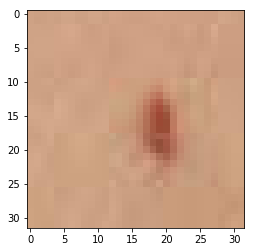

[8.9093494e-19 9.9999225e-01]
Press Enter to continue...


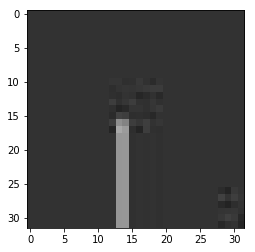

[1.5774125e-11 9.9997902e-01]
Press Enter to continue...


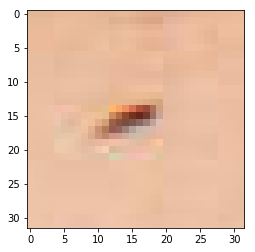

[1.6534965e-10 9.8799127e-01]
Press Enter to continue...


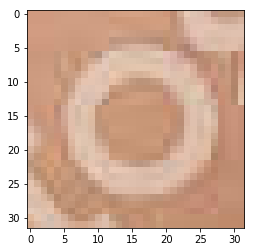

[2.8883531e-33 9.9890137e-01]
Press Enter to continue...


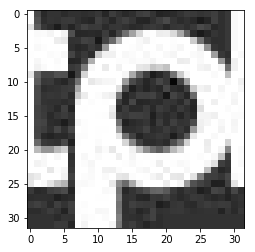

[1.5884946e-07 9.9973661e-01]
Press Enter to continue...


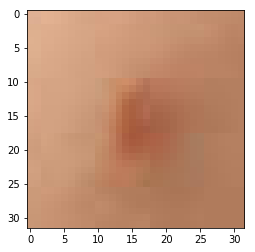

[8.627504e-07 8.579138e-01]
Press Enter to continue...


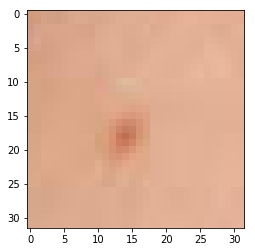

[0.35627308 0.76058435]
Press Enter to continue...


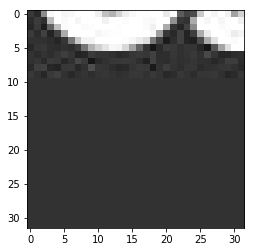

[6.7871660e-11 9.8851305e-01]
Press Enter to continue...


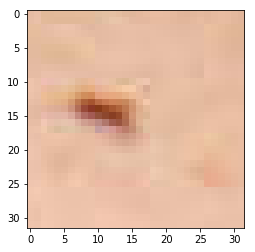

[8.0627518e-07 9.9894387e-01]
Press Enter to continue...


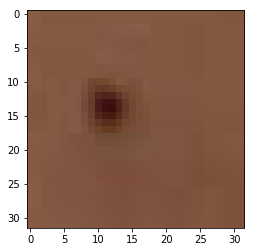

[1.9893403e-34 9.9999523e-01]
Press Enter to continue...


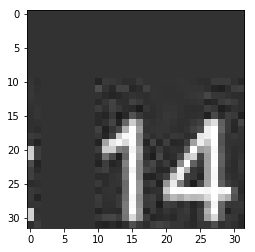

[2.5571649e-09 9.9803036e-01]
Press Enter to continue...


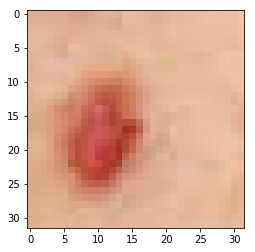

[3.147644e-11 9.995253e-01]
Press Enter to continue...


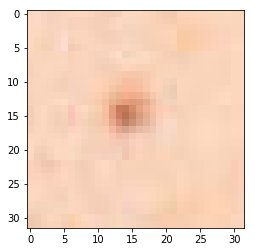

[2.732394e-12 9.999958e-01]
Press Enter to continue...


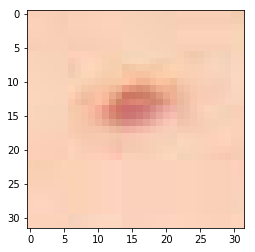

[2.694677e-10 9.999502e-01]
Press Enter to continue...


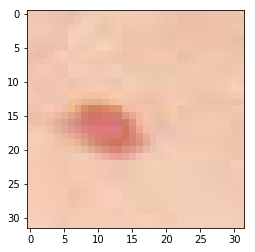

[4.2097543e-08 6.7729980e-01]
Press Enter to continue...


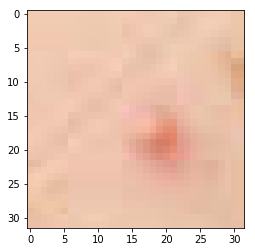

[2.5573492e-04 5.7191986e-01]
Press Enter to continue...


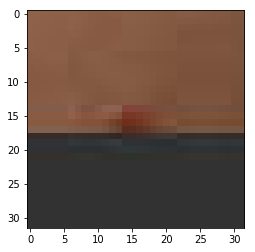

[1.4966316e-08 9.7406578e-01]
Press Enter to continue...


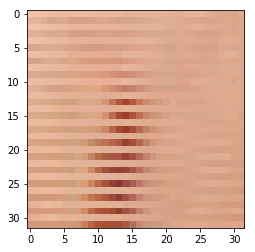

[1.4557148e-13 1.0000000e+00]
Press Enter to continue...


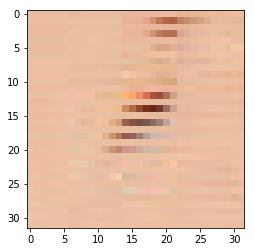

[1.1545478e-12 8.2638228e-01]
Press Enter to continue...


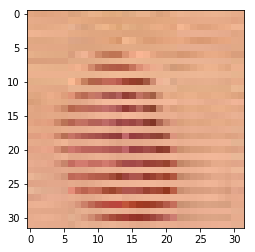

[1.0459803e-11 9.9264812e-01]
Press Enter to continue...


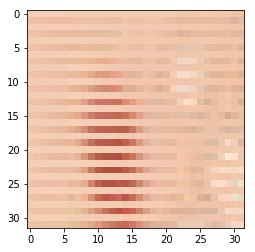

[3.8316785e-09 6.1444122e-01]
Press Enter to continue...


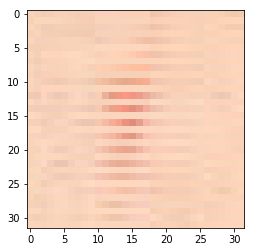

[1.3065324e-10 9.9998605e-01]
Press Enter to continue...


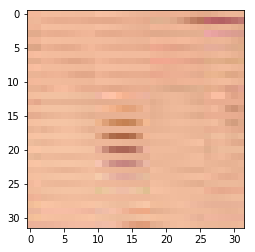

[2.0870795e-11 9.6616024e-01]
Press Enter to continue...


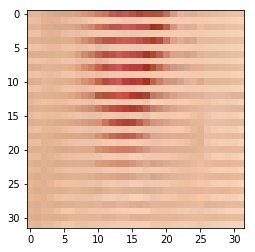

[5.7309578e-14 8.3938265e-01]
Press Enter to continue...


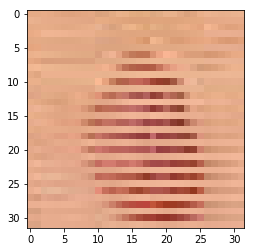

[4.8784752e-12 9.9935013e-01]
Press Enter to continue...


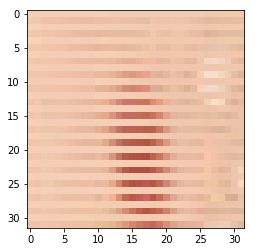

[9.063612e-11 9.582552e-01]
Press Enter to continue...


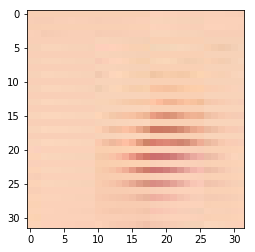

[2.2218813e-13 9.9807966e-01]
Press Enter to continue...


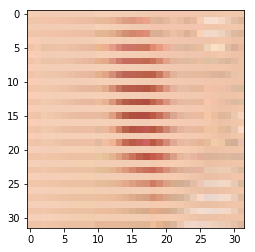

[1.0240457e-16 1.0000000e+00]
Press Enter to continue...


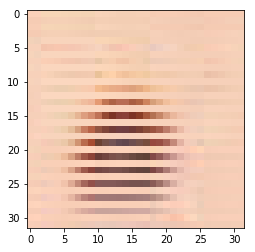

[1.2261539e-11 6.9714367e-01]
Press Enter to continue...


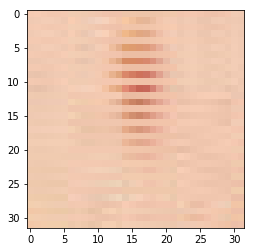

[1.2921158e-11 9.9994349e-01]
Press Enter to continue...


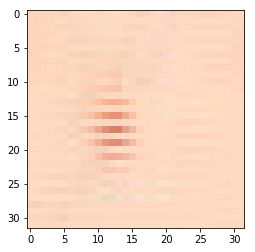

[1.07505576e-11 9.60143447e-01]
Press Enter to continue...


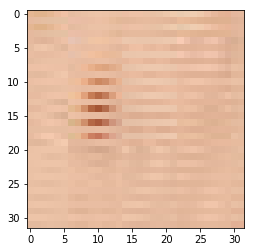

[5.930965e-20 1.000000e+00]
Press Enter to continue...


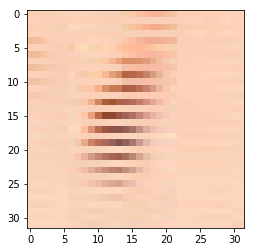

[8.019551e-15 1.000000e+00]
Press Enter to continue...


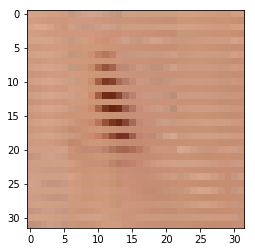

[2.978021e-15 1.000000e+00]
Press Enter to continue...


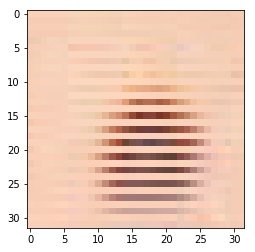

[7.9367225e-12 9.4953340e-01]
Press Enter to continue...


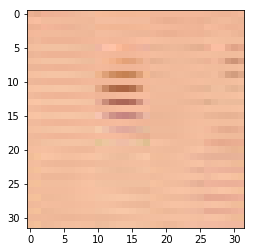

[1.7733802e-11 9.9943763e-01]
Press Enter to continue...


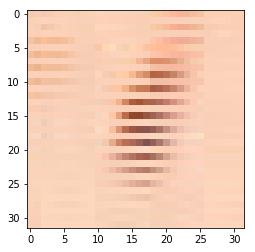

[1.7473283e-12 9.9999988e-01]
Press Enter to continue...


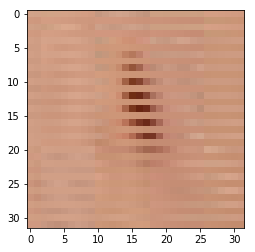

In [82]:
model = load_model('cnn_weights.hdf5')
preds = model.predict(w1Scaled)
count=0

for i in range(0,preds.shape[0]):
    if preds[i,1] > 0.5:
        count+=1
        figure = plt.figure()
        plt.imshow(w1input[i,:,:,:])
        print(preds[i])
        input("Press Enter to continue...")
        plt.show()

In [83]:
print('Megtalált anyajegyek a képen:',count)

Megtalált anyajegyek a képen: 74
